In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import warnings
import time

from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from spacy.lang.ru import Russian
from typing import Callable
from IPython.core.display import display

pd.options.display.width = 0
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

# Задача исследования  

Интернет-магазин хочет сегментировать своих покупателей, желая таргетировать рекламу более аккуратно. Наша задча - выделить сегменты и проверить, что интересующие метрики для этих сегментов статистически различны  


# EDA  



In [3]:
try:
    from paths import final_project_url

    df = pd.read_csv(final_project_url)
except ModuleNotFoundError:
    print('Data not for public use, sorry')
    raise

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df['day'] = df['date'].astype('datetime64[D]')

In [6]:
df.sample(5, random_state=42)

,date,customer_id,order_id,product,quantity,price,day
381,2018-10-23 13:00:00,49b9c587-c19e-4481-bace-967aeac357fa,14494,Пеларгония зональная диам. 12 см сиреневый про...,1,188.0,2018-10-23
2476,2019-03-26 14:00:00,c816fd3d-3783-4fd8-aeab-0e99fab4eb58,70888,Пеларгония розебудная Prins Nikolai укорененны...,1,134.0,2019-03-26
2855,2019-04-15 11:00:00,a478c83a-0590-4757-b50b-8db523052a3c,71130,Настенная сушилка для белья Gimi Brio Super 120,1,899.0,2019-04-15
2018,2019-02-25 14:00:00,7e5a2981-f529-45c5-a1db-d645a61b356b,14548,Пеларгония Toscana Angeleyes Bicolor укорененн...,1,112.0,2019-02-25
2185,2019-03-05 11:00:00,051edfd2-b09e-4e48-b12d-cf6ab2fdcc5f,70599,Тюльпан Louvre (Лувр) Бахромчатый 25 шт,15,37.0,2019-03-05


## Корректность данных

In [7]:
df.duplicated().sum()

0

Явных "полных" дублей в датасете нет 

In [8]:
(df.groupby(['order_id'])
 .agg({'day': [lambda x: x.max() - x.min(), 'nunique']})
 .reset_index()
 .sort_values(('day', '<lambda_0>'), ascending=False)
 .head(10)
 )

order_id        day        
              <lambda_0> nunique
1658    70960   210 days      57
2004    71663    87 days       4
1049    69797    83 days       2
933     69531    73 days      11
1939    71542    71 days       3
1712    71054    59 days       5
817     69310    54 days       4
533     68814    53 days       2
1754    71148    51 days      11
959     69586    50 days       3

Со слов заказчика, мы видим следствие ошибки обработки данных на их стороне - один номер заказа присутствует во множество разных дней. Считаем, что реальные данные - те, что относятся к первому дню, в который появляется заказ, а остальные вхождения этого же номера заказа удалим

In [9]:
tdf = df.groupby(['order_id']).agg({'day': 'min'}).reset_index()
df = df.merge(tdf)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5010 entries, 0 to 5009
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5010 non-null   datetime64[ns]
 1   customer_id  5010 non-null   object        
 2   order_id     5010 non-null   int64         
 3   product      5010 non-null   object        
 4   quantity     5010 non-null   int64         
 5   price        5010 non-null   float64       
 6   day          5010 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 313.1+ KB


In [10]:
print(f'Удалили {6737 - df.shape[0]} строк, {(6737 - df.shape[0]) / 6737:.2%} датасета')

Удалили 1727 строк, 25.63% датасета


## Date

In [11]:
df['day'].describe()

count                    5010
unique                    391
top       2019-04-24 00:00:00
freq                       85
first     2018-10-01 00:00:00
last      2019-10-31 00:00:00
Name: day, dtype: object

In [12]:
df['day'].max() - df['day'].min()

Timedelta('395 days 00:00:00')

У нас есть данные с 2018-10-01 по 2019-10-31, 395 дней

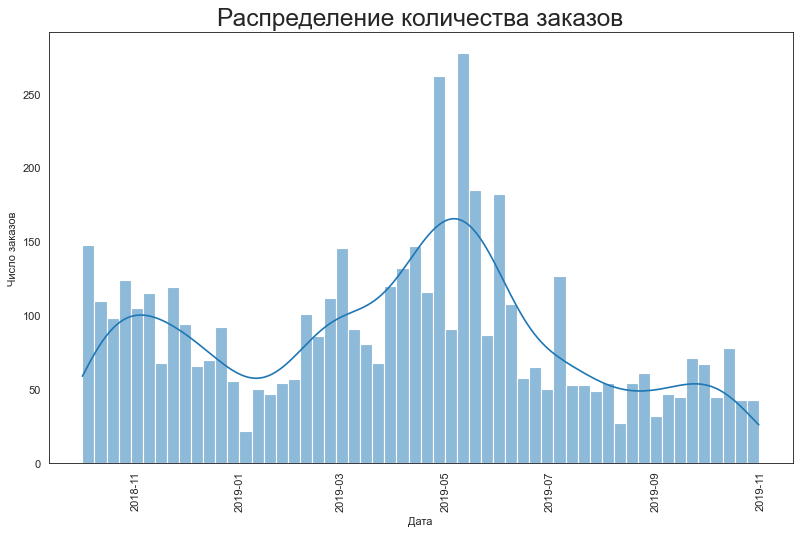

In [13]:
sns.set_style("white")

plt.figure(figsize=(12, 7), dpi=80)
sns.histplot(df, x='day', kde=True, bins=56)
plt.title('Распределение количества заказов', fontsize=22)
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.show()

Количество транзакций меняется в течении нашего периода, виден всплеск в апреле, мае, июне, июле

## Customer_id, order_id   

In [14]:
df['customer_id'].nunique()

2426

In [15]:
df['order_id'].nunique()

2784

In [16]:
tdf = (df.groupby(['customer_id'])
       .agg({'order_id': 'nunique'})
       .reset_index()
       .sort_values(('order_id'), ascending=False)
       )

tdf['order_id'].describe(percentiles=(0.75, 0.95, 0.99))

count    2426.000000
mean        1.150041
std         2.668749
min         1.000000
50%         1.000000
75%         1.000000
95%         2.000000
99%         3.000000
max       126.000000
Name: order_id, dtype: float64

1.1 заказа в среднем на пользователя, только 5% больше одного заказа, только 1% больше двух

## Product

In [17]:
df['product'].nunique()

2338

In [18]:
tdf = (df.groupby(['product'])
       .agg({'order_id': 'nunique'})
       .reset_index()
       .sort_values(('order_id'), ascending=False)
       )

tdf['order_id'].describe(percentiles=(0.75, 0.95, 0.99))

count    2338.000000
mean        2.055603
std         3.316094
min         1.000000
50%         1.000000
75%         2.000000
95%         6.000000
99%        14.630000
max        65.000000
Name: order_id, dtype: float64

In [19]:
tdf.head()

,product,order_id
1040,Пеларгония розебудная Red Pandora укорененный ...,65
1038,Пеларгония розебудная Prins Nikolai укорененны...,55
1015,Пеларгония зональная диам. 12 см сиреневый пол...,52
1615,Сумка-тележка 2-х колесная Gimi Argo синяя,47
1037,Пеларгония розебудная Mary укорененный черенок,39


2338 уникальных товара, в среднем каждый товар попал в два заказа, 5% - в шесть, наиболее популярный - в 65

## Quantity, price

In [20]:
df['quantity'].describe(percentiles=(0.75, 0.95, 0.99))

count    5010.000000
mean        2.814571
std        17.381046
min         1.000000
50%         1.000000
75%         1.000000
95%         8.000000
99%        30.000000
max      1000.000000
Name: quantity, dtype: float64

1000 единиц товара в одном заказе при среднем в 2.8 - очень сильный выброс, учитывая, что только 1% заказов имеет больше 30 одинаковых предметов в нём

In [21]:
df.sort_values('quantity', ascending=False).head(10)

,date,customer_id,order_id,product,quantity,price,day
3944,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,2019-06-18
3870,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06-11
3480,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,2019-05-20
1041,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,2018-12-10
500,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,2018-11-01
2135,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0,2019-03-23
204,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150,38.0,2018-10-11
203,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,2018-10-11
518,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,2018-11-02
1375,2019-01-21 09:00:00,8eabcaca-e8c8-4eee-9079-4ff5f612273a,69893,Щетка для мытья посуды КОЛИБРИ М5202 большая,100,34.0,2019-01-21


1000 вантузов, 300 вешалок, муляжи яблок. Отбросим заказ с вантузами, он отличается более чем втрое от следующего 

In [22]:
df = df.query('order_id != 71743')

In [23]:
df['price'].describe(percentiles=(0.75, 0.95, 0.99))

count     5009.000000
mean       515.175684
std        943.852995
min          9.000000
50%        150.000000
75%        488.000000
95%       2243.000000
99%       4956.360000
max      14917.000000
Name: price, dtype: float64

Половина покупок приходится на товары дешевле 150р, 5% - дороже 2250р

In [24]:
df.sort_values('price', ascending=False).head(10)

,date,customer_id,order_id,product,quantity,price,day
4331,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0,2019-07-29
2373,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,Сумка-тележка хозяйственная Andersen Royal Sho...,1,8737.0,2019-04-05
1741,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,Сумка-тележка хозяйственная Andersen Alu Star ...,1,8437.0,2019-02-24
2642,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo...,1,8077.0,2019-04-21
4916,2019-10-16 15:00:00,d5584388-ffbe-42fd-a746-a98828ec919f,72992,Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 ...,1,7724.0,2019-10-16
2051,2019-03-14 18:00:00,27d4ce42-352b-4756-bf5b-8724e05d5131,70740,Сумка-тележка хозяйственная Rolser IMX006 bass...,1,7679.0,2019-03-14
4332,2019-07-30 01:00:00,e2fe6b48-1955-4882-925c-733f545df026,72140,Сумка-тележка хозяйственная Rolser MNB017 fucs...,1,7679.0,2019-07-30
583,2018-11-05 22:00:00,fc333417-1d11-4a2a-b946-0957ae0603e9,68872,Сумка-тележка хозяйственная Rolser MOU041 malv...,1,7597.0,2018-11-05
1112,2018-12-17 17:00:00,86c97bf1-c834-423e-9e38-8acda68f97e8,69417,Гладильная доска Leifheit AirBoard Compact M P...,1,7424.0,2018-12-17
4495,2019-08-23 12:00:00,8d85f320-5f55-4647-814c-da1a6b21c2a4,72381,Урна уличная стальная Сальвадор 02.021.0 46х11...,1,7349.0,2019-08-23


Сушилка уличная выделяется, но от следующих пунктов отстоит не столь сильно. Пока оставим

## Value

Рассчитаем для каждой строчки датасета её стоимость, умножив количество на цену 

In [25]:
df['value'] = df['price'] * df['quantity']

In [26]:
df.groupby('order_id').agg({'value': 'sum'}).describe(percentiles=(0.75, 0.95, 0.99))

,value
count,2783.000000
mean,1279.338843
std,2284.338298
min,14.000000
50%,704.000000
75%,1499.000000
95%,4124.000000
99%,8457.340000
max,49432.000000


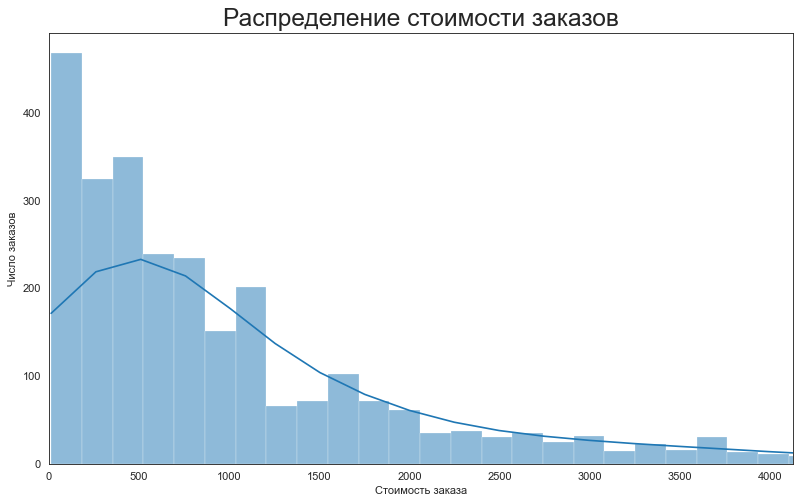

In [27]:
plt.figure(figsize=(12, 7), dpi=80)
sns.histplot(df.groupby('order_id').agg({'value': 'sum'}), x='value', kde=True)
plt.title('Распределение стоимости заказов', fontsize=22)
plt.xlim(0, 4124)
plt.xlabel('Стоимость заказа')
plt.ylabel('Число заказов')
plt.show()

# Сегментация покупателей  


## Категоризация товаров  

Информация о том, какие товары покупает пользователь - важная информация для принятия решения о сегментации. К сожалению, для своих товаров магазин не хранил категорию, нам придётся присвоить её самостоятельно

In [28]:
def timing(func: Callable) -> Callable:
    """
    Декоратор, печатающий время работы обёрнутой функции
    :param func: Callable
    :return: Callable
    """

    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = func(*args, **kwargs)
        time2 = time.time()
        print(f'{func.__name__} function took {(time2 - time1) * 1000.0:.3f} ms to complete')

        return ret

    return wrap

In [29]:
def spacy_tokenizer(document: str) -> list[str]:
    """
    Отфильтровывает числа, "стоп-слова", знаки пунктуации, лемматизирует остальное
    Добавляет в результирующий лист по десять копий первых двух лемм, увеличивая их вес для дальнейших операций
    :param document: строка, которую хотим лемматизировать
    :return: лист лемм
    """
    nlp = Russian()
    tokens = nlp(document)
    tokens = [token.lemma_ for token in tokens if (
            token.is_stop == False and
            token.like_num == False and
            token.is_punct == False and
            token.lemma_.strip() != '')]
    tokens += tokens[:2] * 10
    return tokens

In [30]:
@timing
def tfidf_clustering(i: int, names: list[str]) -> tuple[pd.DataFrame, list[float, int]]:
    """
    Применяет KMeans на матрице значений TF-IDF для названий товаров. Для выделения лемм токенов используется spacy_tokenizer
    :param names: список названий
    :param i: нужное число кластеров
    :return: датафрейм соответствий уникальных названий номеру клатера, WCSS value, число кластеров
    """
    names_df = pd.DataFrame(names)

    tfidf_vectorizer = TfidfVectorizer(input='content', tokenizer=spacy_tokenizer)
    result = tfidf_vectorizer.fit_transform(pd.Series(names))

    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42).fit(result)
    labels = pd.Series(kmeans.labels_)
    print(f'Number of clusters {i}, WCSS value {kmeans.inertia_}')

    names_df = pd.concat([names_df, labels], axis=1)
    names_df.columns = ['product', 'label']
    return names_df, [kmeans.inertia_, i]

Попробуем решить, сколько кластеров мы выделим

In [31]:
wcss = []
for i in range(1, 50, 5):
    wcss.append(tfidf_clustering(i, df['product'].unique())[1])

Number of clusters 1, WCSS value 2301.8676722574146
tfidf_clustering function took 405610.460 ms to complete
Number of clusters 6, WCSS value 1960.3651688020734
tfidf_clustering function took 383263.347 ms to complete
Number of clusters 11, WCSS value 1740.8149885781952
tfidf_clustering function took 453361.395 ms to complete
Number of clusters 16, WCSS value 1642.3863129433378
tfidf_clustering function took 421691.331 ms to complete
Number of clusters 21, WCSS value 1527.0919830605696
tfidf_clustering function took 338844.108 ms to complete
Number of clusters 26, WCSS value 1458.8686562871358
tfidf_clustering function took 306255.913 ms to complete
Number of clusters 31, WCSS value 1406.4869397513337
tfidf_clustering function took 367974.236 ms to complete
Number of clusters 36, WCSS value 1370.7484996613334
tfidf_clustering function took 368654.499 ms to complete
Number of clusters 41, WCSS value 1307.7184383933122
tfidf_clustering function took 381721.056 ms to complete
Number of cl

Построим график Within-Cluster-Sum-of-Squares от количества кластеров 

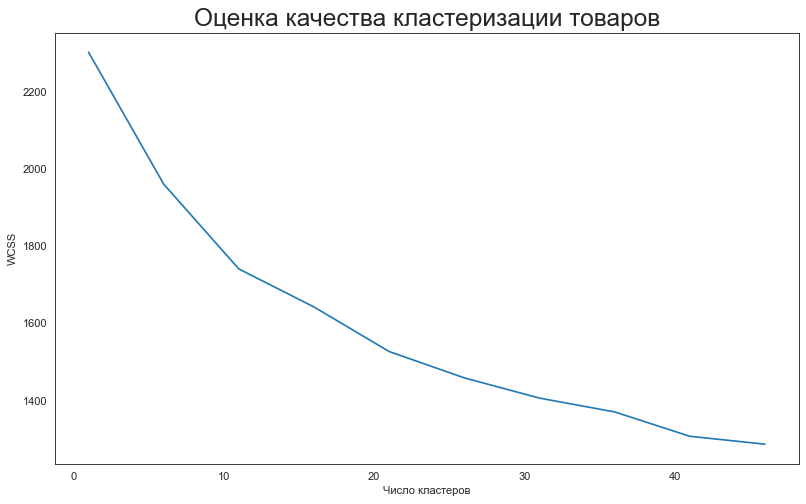

In [32]:
plt.figure(figsize=(12, 7), dpi=80)
sns.lineplot(x=[i[1] for i in wcss], y=[i[0] for i in wcss])
plt.title('Оценка качества кластеризации товаров', fontsize=22)
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

Совсем явного изгиба кривой нет, но 20 кажется допустимым вариантом

In [33]:
tfidf_df = tfidf_clustering(20, df['product'].unique())[0]

Number of clusters 20, WCSS value 1559.3125789392357
tfidf_clustering function took 281297.810 ms to complete


Посмотрим на полученные кластеры

In [34]:
for i in tfidf_df['label'].unique():
    print(f"label {i}, items {tfidf_df.query('label == @i').shape[0]}")
    display(tfidf_df.query('label == @i').sample(6, random_state=42))

label 4, items 26


,product,label
1230,Однолетнее растение Табак душистый в кассете п...,4
1711,"Однолетнее растение Вербена в кассете по 4 шт,...",4
0,"Комнатное растение в горшке Алое Вера, d12, h30",4
2302,Комнатное растение Пуансеттия D10,4
1647,"Однолетнее растение Виола в кассете по 4 шт, Р...",4
1560,"Однолетнее растение Астра в кассете по 4 шт, Р...",4


label 0, items 1009


,product,label
1462,"Чайник эмалированный Орхидея со свистком 2,5 л...",0
1469,Щетка для мытья окон 2 в 1 с телескопической р...,0
1864,Нивянник (Ромашка) крупноцветковый белый объем...,0
1212,Искусственная композиция из цветов пластиковая...,0
877,Простынь вафельная 200х180 см WELLNESS RW180-0...,0
1559,"Лобелия Регатта Regatta микс объем 0,5 л",0


label 3, items 131


,product,label
768,Сушилка для белья на ванну Leifheit Adria 72708,3
639,Сушилка для белья Gimi Dinamik 30,3
206,"Сушилка для белья потолочная Лиана 1,7 м 1703006",3
519,Сушилка для белья ЛИАНА ЛЮКС 120 см потолочная,3
2060,Сушилка для белья ВИОЛЕТ Level 120 L-120 насте...,3
808,Сушилка для белья потолочная ЛИАНА ЛЮКС 180 см...,3


label 6, items 35


,product,label
1513,"Таз пластмассовый строительный круглый 40 л, 1...",6
237,"Таз пластмассовый 16,0 л пищевой с ручками (С2...",6
931,"Таз пластмассовый 16,0 л пищевой круглый М2507...",6
641,"Таз пластмассовый 8,0 л пищевой (Минеральные в...",6
274,"Таз пластмассовый 32,0 л с ручками ""Полимербыт...",6
2057,"Таз пластмассовый 30,0 л овальный (Белоруссия)...",6


label 19, items 57


,product,label
9,Чехол для гладильной доски Colombo Persia Beig...,19
208,Чехол для гладильной доски Zalger 520138 140х5...,19
883,Чехол для одежды Hausmann розовый принт 60х100...,19
371,Чехол для гладильной доски I LOVE GIMI L из по...,19
964,Чехол для гладильной доски I LOVE GIMI M из по...,19
2322,Чехол для гладильной доски PRISMA TEXTIL термо...,19


label 10, items 46


,product,label
2061,Вешалка настенная НИКА ВПТ11б с полкой 11 крюч...,10
882,Вешалка Valiant для брюк и юбок металлическая ...,10
925,Набор вешалок пластмассовых Rozenbal R181900,10
2285,Вешалка для блузок 41 см красный Attribute AHM781,10
1900,Вешалка-стойка Сакура Слуга 2 на колесах сосна,10
2129,Вешалка - слуга Малая ЗМИ белое серебро ВНП 141 б,10


label 9, items 72


,product,label
257,"Гладильная доска ДСП ""БЭЛЛЬ-ЮНИОР2"", 112*34,5,...",9
1769,Гладильная доска НИКА 11 122х40 см Н11,9
500,Гладильная доска НИКА BRUNA M HBM 122х40 см,9
19,Доска гладильная Eurogold Professional 130х48 ...,9
726,Гладильная доска Eurogold Professional 130х48 ...,9
1108,Гладильная доска Hausmann Classic MONO 120x38 ...,9


label 1, items 103


,product,label
461,Сумка-тележка хозяйственная GIMI Ideal серая (...,1
1201,Сумка-тележка хозяйственная Rolser Jet Claudia...,1
1044,Сумка-тележка 2-х колесная Gimi Argo фиолетовая,1
798,Сумка-тележка 3-х колесная Gimi Tris черная,1
635,"Сумка-тележка TWIN стальной каркас 56 л синяя,...",1
556,Сумка-тележка GIMI Argo красная,1


label 2, items 177


,product,label
1102,Рассада зелени для кухни Тимьян Вульгарис Комп...,2
1448,Рассада Арбуза сорт Огонек горшок 9х9 см P-9,2
1809,"Рассада Огурца сорт Магнат, кассета по 6шт",2
1327,Рассада зелени для кухни Лаванда Прованc диам....,2
1506,Рассада зелени для кухни Сантолина Хамаекипари...,2
1056,Рассада пряной травы Лавр в горшке 9 см,2


label 8, items 68


,product,label
455,Муляж Гранат мини 4 шт,8
41,"Муляж ЧЕРЕШНЯ 3см 10 шт., желтый, Fancy Fair, ...",8
29,"Муляж Груша мини 2 шт, желтая 4 см",8
34,Муляж Красное яблоко мини полиуретан d-6 см,8
291,Муляж ГРАНАТ 9 см красный,8
410,Муляж Персик 9 см полиуретан,8


label 11, items 94


,product,label
662,Тарелка суповая ВОЛАРЭ БЛЭК 23 см G9402 Luminarc,11
562,Салатник РОМАНТИК ГАРДЕН 17 см J7900 Luminarc,11
959,Чайный набор Luminarc ЛИЛИ ФЛАУЭР 6 шт 320 мл ...,11
1215,Подарочный набор на 8 Марта Нарцисс 5 луковиц ...,11
45,"Тарелка обеденная ЛИМОН ФИЦ 25см, G9547, Lumin...",11
573,"Салатник Luminarc АРТИ ГРИН 16,5 см J1392",11


label 18, items 9


,product,label
2032,Вилка столовая 3 предмета Кокос СВК102,18
47,"Ложка столовая RIPPLE сталь 3 мм, 3 шт, Attrib...",18
862,Вилка столовая 3 шт тяжелая серия Сапфир СВWed...,18
46,"Вилка столовая RIPPLE сталь 3 мм, 3 шт, Attrib...",18
2149,Столовая ложка 3 шт Боннтяжелая СЛBonn-2,18
470,Вилка столовая Better цветной горох BT-C2003E-...,18


label 5, items 82


,product,label
290,Пеларгония зональная диам. 12 см малиново-крас...,5
50,Герань домашняя (пеларгония зональная) цветуща...,5
181,Герань домашняя (пеларгония зональная) цветуща...,5
306,Пеларгония зональная диам. 12 см белая махровая,5
168,Пеларгония зональная махровая лососевая,5
225,Герань домашняя (пеларгония зональная) цветуща...,5


label 17, items 78


,product,label
743,"Коврик придверный каучуковый 45х75 см черный, ...",17
62,Коврик придверный 45х75см. с рельефным рисунко...,17
751,Ковер придверный EKSPO 90х150 см коричневый РР...,17
320,Коврик придверный грязеулавливающий резиновый ...,17
318,Коврик влаговпитывающий ребристый 50х80 см Ста...,17
2318,"Коврик придверный, полипропилен, 40х70 см, Kok...",17


label 14, items 54


,product,label
1018,Искусственный цветок Ландыш пластиковый малый ...,14
2145,Цветок искусственный Подсолнух 60 см,14
2123,Искусственный цветок Роза открытая малая пласт...,14
350,Цветок искусственный Тюльпан в ассортименте од...,14
1717,Искусственный цветок Букет Примулы пластиковая...,14
343,Цветок искусственный Гвоздика пластиковая один...,14


label 13, items 59


,product,label
125,"Штора текстильная для ванны и душа полиэстер, ...",13
246,Штора со встроенными кольцами под штангу для в...,13
1262,Штора для ванной комнаты SHINE полиэстер 180х2...,13
539,Штора для ванной с кольцами RL-0071 Мыльные пу...,13
1630,Штора со встроенными кольцами под штангу для в...,13
2069,Штора для ванной комнаты TEX Four полиэстер 18...,13


label 12, items 19


,product,label
248,Сантолина d-9 см,12
524,Мята d-9 см,12
1157,Мирт d-9 см h-15 см,12
273,Фиалка d-11 см,12
945,Фиалка d-9 см белая махровая,12
1926,Гардения d-9 см укорененный черенок,12


label 16, items 49


,product,label
1149,Роза садовая чайногибридная в горшке Императрица,16
2076,Роза садовая чайногибридная в горшке Сатина,16
2162,Роза чайно-гибридная Восточный Экспресс сливоч...,16
2075,Роза садовая чайногибридная в горшке Блек Бакара,16
1285,Роза мини оранжевая d-7 см h-10,16
1914,Роза садовая парковая в горшке Дипп Ватер,16


label 15, items 73


,product,label
1232,Петуния махровая рассада однолетних цветов в к...,15
1857,Петуния ампельная Розовая в горшке P9,15
1429,Петуния Surfinia Doble Lilac светло-сиреневая ...,15
354,"Бегония ампельная, диам. 12 см",15
1562,Петуния Pegasus Qeen of Hearts красные сердца ...,15
2281,Фуксия ампельная темно-фиолетовая с вишневыми ...,15


label 7, items 96


,product,label
1623,томата (помидор) Улыбка Розы № 113 сорт детерм...,7
1620,томата (помидор) Синий тигр №75 сорт индетерми...,7
1616,томата (помидор) Полосатый шоколад №65 сорт ин...,7
1842,Томат детерминантный Сердолик в кассете 6 штук...,7
1537,томата (помидор) Джалпа №25 сорт детерминантны...,7
1622,томата (помидор) Спящая леди № 108 сорт детерм...,7


Для дальнейшего анализа нам будет удобно объединить кластеры в несколько групп

In [35]:
items_categories = {
    'Растения': [4, 7, 2],
    'Утварь (разное)': [18, 11, 0],
    'Цветы': [15, 16, 12, 5],
    'Хозтовары': [13, 0, 17, 1, 9, 6, 3, 10, 19],
    'Муляжи': [14, 8]
}

Присвоим каждому товару метку в зависимости от его кластера 

In [36]:
def categories_merge(value: int) -> str:
    for k, v in items_categories.items():
        if value in v:
            return k


In [37]:
tfidf_df['label'] = tfidf_df['label'].apply(categories_merge)
tfidf_df.sample(5, random_state=42)

,product,label
1720,"Однолетнее растение Газания в кассете по 4 шт,...",Растения
2025,Шалфей овощной Нектар в кассете 4 штуки,Утварь (разное)
1430,Петуния Surfinia Doble White белая махровая об...,Цветы
2320,"Полки QWERTY Пекин белый/чёрный 95х17,5х16 см ...",Утварь (разное)
2141,Махровое полотенце 50х30 см WELLNESS *АМЕЛИ_1-...,Утварь (разное)


Присвоим каждой строке в основной таблице соответствующую её товару метку кластера 

In [38]:
df = df.merge(tfidf_df, on='product')
df.sample(5, random_state=42)

,date,customer_id,order_id,product,quantity,price,day,value,label
2503,2019-05-18 15:00:00,2459fe55-74d9-4e11-b82a-5265594f255e,14791,Пеларгония Toscana Angeleyes Bicolor укорененн...,1,112.0,2019-05-18,112.0,Цветы
3509,2019-07-01 20:00:00,713141d7-bbaf-4da9-b43d-f91bd51b423c,14882,Рассада зелени для кухни Мелисса лимонная зеле...,2,89.0,2019-07-01,178.0,Растения
4267,2019-06-05 00:00:00,9faf2099-1571-4c7f-86ac-ebb4c086c317,14847,Рассада Кабачка сорт Белогор кассета 6 шт E6,3,120.0,2019-06-05,360.0,Растения
1609,2018-11-21 16:00:00,85777bd0-9edd-4e15-8bb7-a6f5090a31cd,69077,Дендробиум Санок Полар Файр 1 ствол d-12 см,1,922.0,2018-11-21,922.0,Утварь (разное)
3357,2019-09-01 12:00:00,4ede57e4-2842-4be6-b378-e0123f3770e7,72468,"Полки QWERTY Рио белый/чёрный 42,5х21х10 см 17...",1,1949.0,2019-09-01,1949.0,Утварь (разное)


In [39]:
df.groupby('label').agg({'quantity': 'count'})

,quantity
label,
Муляжи,267
Растения,767
Утварь (разное),1604
Хозтовары,1210
Цветы,1161


## Сегментация пользователей

Имея данные по категориям товаров, попробуем выделить кластеры пользователей

Для нашей новой категориальной переменной `label` получим набор из пяти столбцов со значениями 0 или 1

In [40]:
df = df.join(pd.get_dummies(df['label']))

Получим таблицу, где для каждого пользователя запишем следующую информацию: количество купленных товаров для каждой категории, число пользовательских заказов, общее количество купленных предметов, общая стоимость всех покупок 

In [41]:
users_df = (df.groupby(['customer_id'])
    .agg(
    {'Муляжи': 'sum', 'Растения': 'sum', 'Хозтовары': 'sum', 'Утварь (разное)': 'sum', 'Цветы': 'sum',
     'order_id': 'nunique',
     'quantity': 'sum',
     'value': 'sum'})
)
users_df.head(5)

,Муляжи,Растения,Хозтовары,Утварь (разное),Цветы,order_id,quantity,value
customer_id,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,0,0,0,0,4,1,4,555.0
001cee7f-0b29-4716-b202-0042213ab038,0,0,1,0,0,1,1,442.0
00299f34-5385-4d13-9aea-c80b81658e1b,0,0,0,1,0,1,2,914.0
002d4d3a-4a59-406b-86ec-c3314357e498,0,0,1,0,0,1,1,1649.0
003bbd39-0000-41ff-b7f9-2ddaec152037,0,0,0,1,0,1,2,2324.0


Стандартизируем нашу таблицу

In [42]:
scaler = StandardScaler()
scaler.fit(users_df)
res = scaler.transform(users_df)
res

array([[-0.15399768, -0.15736426, -0.295928  , ..., -0.05624478,
        -0.0733805 , -0.20598125],
       [-0.15399768, -0.15736426,  0.29715085, ..., -0.05624478,
        -0.23034702, -0.23146934],
       [-0.15399768, -0.15736426, -0.295928  , ..., -0.05624478,
        -0.17802485, -0.12500582],
       ...,
       [-0.15399768, -0.15736426, -0.295928  , ..., -0.05624478,
        -0.23034702, -0.24342393],
       [-0.15399768, -0.15736426, -0.295928  , ..., -0.05624478,
        -0.23034702, -0.11147232],
       [-0.15399768, -0.15736426,  0.29715085, ..., -0.05624478,
        -0.23034702, -0.20101897]])

In [43]:
type(res)

numpy.ndarray

In [44]:
@timing
def user_clustering(i: int, matrix: np.ndarray) -> tuple[pd.DataFrame, list[float, int]]:
    """
    Применяет k-means на стандартизированной матрице признаков, пришивает к 'users_df' столбец с полученными кластерами
    :param i: число кластеров
    :param matrix: стандартизированная версия 'users_df'
    :return:  результирующий датафрем, лист с WCSS value и числом кластеров
    """
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42).fit(matrix)
    labels = pd.Series(kmeans.labels_)
    print(f'Number of clusters {i}, WCSS value {kmeans.inertia_}')
    clustering_df = users_df.reset_index()
    clustering_df = clustering_df.merge(labels.rename('categories'), left_index=True, right_index=True)
    return clustering_df, [kmeans.inertia_, i]


Number of clusters 1, WCSS value 19400.00000000005
user_clustering function took 846.843 ms to complete
Number of clusters 2, WCSS value 12797.995022070172
user_clustering function took 100.538 ms to complete
Number of clusters 3, WCSS value 10626.987291155228
user_clustering function took 389.461 ms to complete
Number of clusters 4, WCSS value 8816.45039341723
user_clustering function took 226.820 ms to complete
Number of clusters 5, WCSS value 7496.234284134473
user_clustering function took 259.459 ms to complete
Number of clusters 6, WCSS value 6079.3573645993865
user_clustering function took 362.098 ms to complete
Number of clusters 7, WCSS value 5442.117879912194
user_clustering function took 385.130 ms to complete
Number of clusters 8, WCSS value 4986.985976188636
user_clustering function took 382.282 ms to complete
Number of clusters 9, WCSS value 4551.142741892514
user_clustering function took 347.971 ms to complete
Number of clusters 10, WCSS value 4024.9534283832313
user_clus

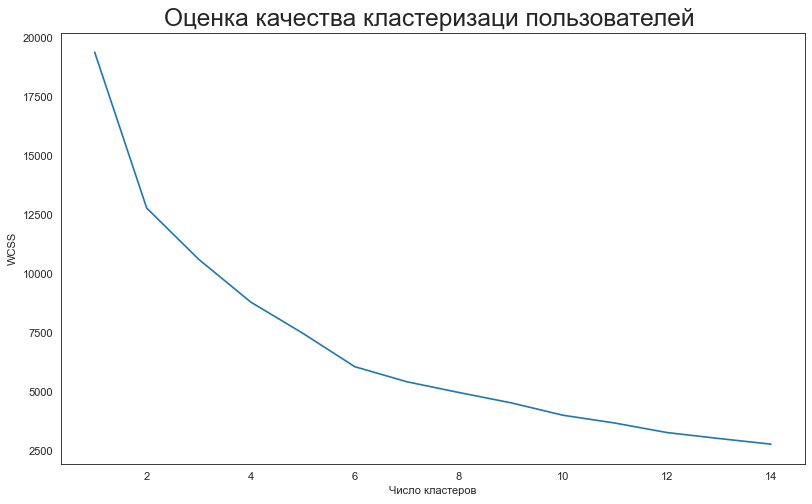

In [45]:
wcss = []
for i in range(1, 15):
    wcss.append(user_clustering(i, res)[1])

plt.figure(figsize=(12, 7), dpi=80)
sns.lineplot(x=[i[1] for i in wcss], y=[i[0] for i in wcss])
plt.title('Оценка качества кластеризаци пользователей ', fontsize=22)
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

Выделим из полученной матрицы восемь кластеров

In [46]:
users_df_copy = user_clustering(8, res)[0]

Number of clusters 8, WCSS value 4986.985976188636
user_clustering function took 2752.750 ms to complete


In [47]:
for i in users_df_copy['categories'].unique():
    print(f"categories {i}, items {users_df_copy.query('categories == @i').shape[0]}")

categories 7, items 1344
categories 1, items 960
categories 3, items 20
categories 0, items 17
categories 4, items 75
categories 5, items 7
categories 6, items 1
categories 2, items 1


Выбросим три самых мелких категории, они не нужны для анализа  

In [48]:
users_df_copy = users_df_copy.query('categories in [7, 1, 3, 0, 4]')

Посмотрим, как распределено LTV для разных категорий

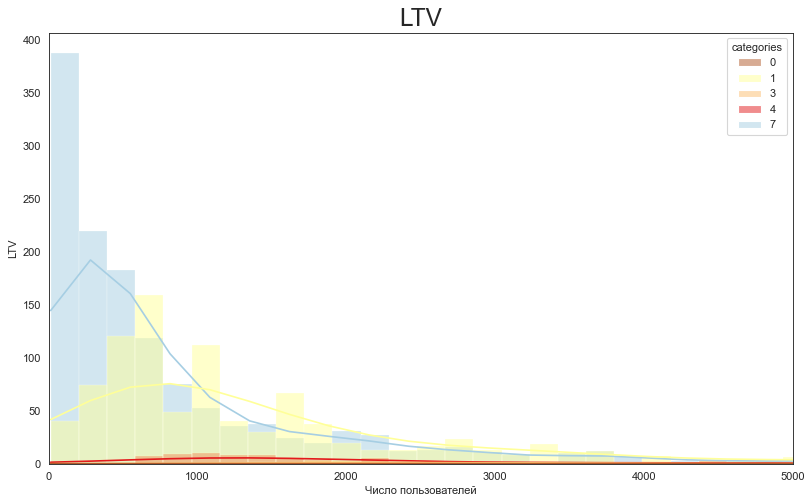

In [49]:
sns.set_palette('Paired_r')

plt.figure(figsize=(12, 7), dpi=80)
sns.histplot(users_df_copy, x='value', hue='categories', kde=True, palette='Paired_r')
plt.title('LTV', fontsize=22)
plt.xlim(0, 5000)
plt.xlabel('Число пользователей')
plt.ylabel('LTV')
plt.show()

Заметно, что категория 1 в среднем приносит больше денег, чем категория 7. Проверим это впоследствии

Получим таблицу вкладов кажой категории покупателей в продажи по типам товаров

In [50]:
shares = users_df_copy.groupby('categories').agg({
    'Цветы': lambda x: x.sum() / users_df_copy['Цветы'].sum(),
    'Утварь (разное)': lambda x: x.sum() / users_df_copy['Утварь (разное)'].sum(),
    'Хозтовары': lambda x: x.sum() / users_df_copy['Хозтовары'].sum(),
    'Растения': lambda x: x.sum() / users_df_copy['Растения'].sum(),
    'Муляжи': lambda x: x.sum() / users_df_copy['Муляжи'].sum()
}
).reset_index()
shares

,categories,Цветы,Утварь (разное),Хозтовары,Растения,Муляжи
0,0,0.000000,0.020248,0.011649,0.000000,0.016575
1,1,0.003506,0.026127,0.978495,0.001304,0.011050
2,3,0.035933,0.061398,0.000000,0.469361,0.000000
3,4,0.543383,0.073155,0.000000,0.076923,0.000000
4,7,0.417178,0.819073,0.009857,0.452412,0.972376


In [51]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
for i, ctg in enumerate(items_categories.keys()):
    sns.barplot(x="categories", y=ctg, data=shares, ax=axs[i])
    axs[i].title.set_text(ctg)
    axs[i].set_ylabel('fraction of total')
    axs[i].set_xlabel('')

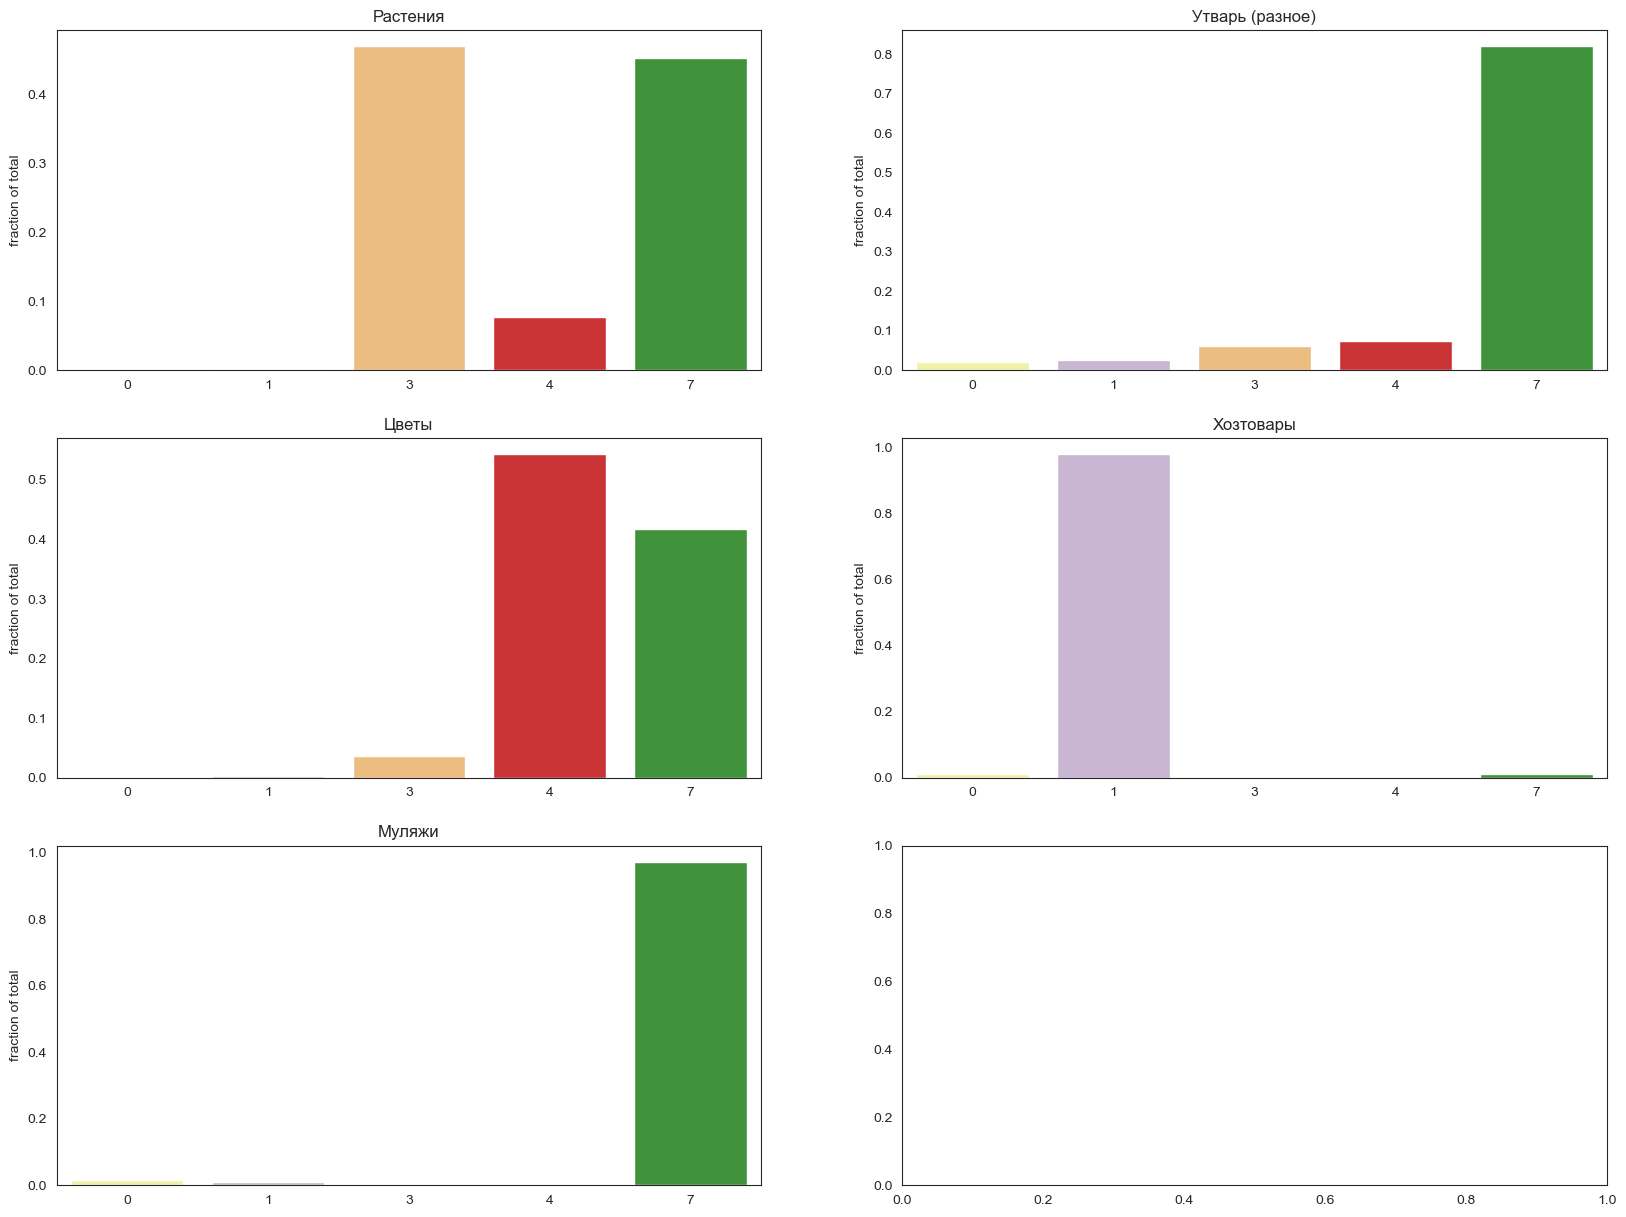

In [52]:
plt.show()

Основные наши категории пользователей - 1 и 7. Для 1 почти все товары относятся к 'Ремонту и утвари', а 7 категория имеет значительный вклад во всех других типах продукции
Категория четыре отвечает за более чем половину покупок 'Цветов', а категория 3 - за половину 'Растений'

# Проверка статистических гипотез

Надо проверить, что наше разбиение на группы пользователей оправданно и несёт какой-то смысл  
Мы хотим давать пользователям более релевантную рекламу, чтоб это проверить, посмотрим, есть ли статистическая разница между двумя нашими основными категориями покапателей 

Смерджим инфу по категориям юзеров с общей табицей. Далее рассматривать будем только две наиболее крупные категории наших пользователей, так как другие слишком малы для полноценного статанализа

In [53]:
tdf = df.copy()
tdf = tdf.merge(users_df_copy.query('categories in [1, 7]')[['customer_id', 'categories']], on='customer_id')
tdf.sample(1, random_state=42)

,date,customer_id,order_id,product,quantity,price,day,value,label,Муляжи,Растения,Утварь (разное),Хозтовары,Цветы,categories
291,2019-01-22 22:00:00,76593172-0856-4cae-8b43-51c1440b7f6b,69934,Эхеверия Перл Фон Нюрнберг d-7 см,1,119.0,2019-01-22,119.0,Утварь (разное),0,0,1,0,0,7


Посмотрим на продажи за анализируемый период в резрезе категорий покупателей

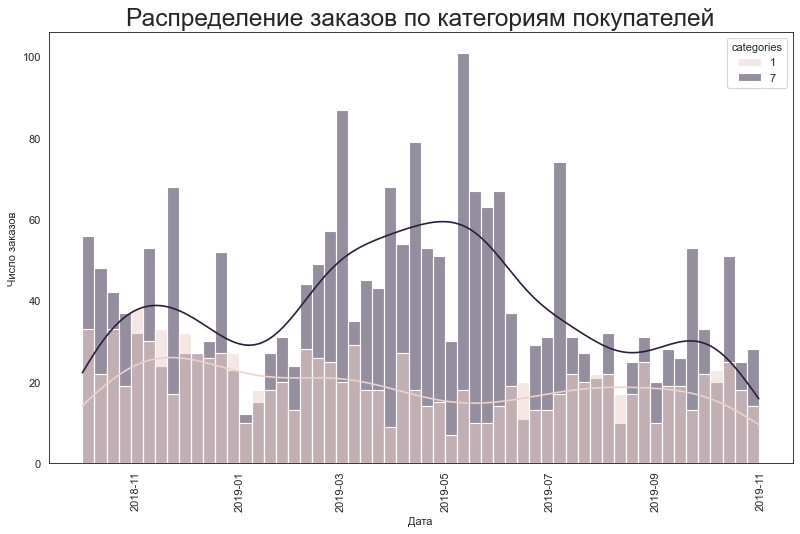

In [54]:
sns.set_style("white")

plt.figure(figsize=(12, 7), dpi=80)
sns.histplot(tdf, x='day', kde=True, bins=56, hue='categories')
plt.title('Распределение заказов по категориям покупателей', fontsize=22)
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.show()

Категория 1 покупает примерно одинаково, а активность категории 7 имеет заметный пик весной-летом

Посмотрим, как меняются продажи типов товаров в течении года

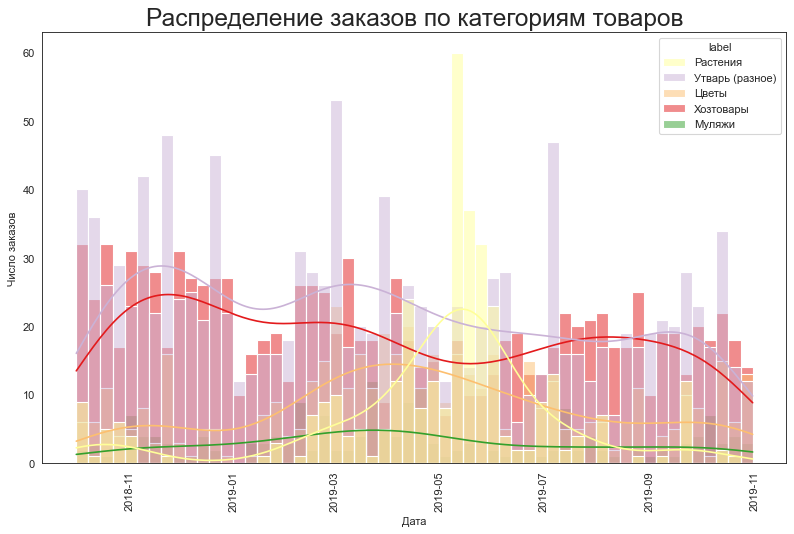

In [55]:
plt.figure(figsize=(12, 7), dpi=80)
sns.histplot(tdf, x='day', kde=True, bins=56, hue='label')
plt.title('Распределение заказов по категориям товаров', fontsize=22)
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.show()

Видно, что продажи 'Цветов' и 'Растений' имеют выраженную сезонность с пиком в конце весны - начале лета

## Средний чек заказа
Сформулируем гипотеу для проверки:
(H0) — средний чек для групп одинаков,
(H1) — средний чек группы 1 выше

In [56]:
order_value = tdf.groupby('order_id').agg({'value': 'sum', 'categories': 'first'}).reset_index()
order_value.groupby(['categories']).agg({'value': ['mean', 'std', 'var']})

value                           
                   mean          std           var
categories                                        
1           1577.511696  1873.309881  3.509290e+06
7            840.225941  1185.336610  1.405023e+06

In [57]:
st.mannwhitneyu(order_value.query('categories == 1')['value'], order_value.query('categories == 7')['value'],
                use_continuity=False, alternative='greater')

MannwhitneyuResult(statistic=1049597.0, pvalue=2.5170877182368115e-73)

Принимаем (H1), p-value пренебрежимо мало, средний чек группы 1 значимо выше

## Продуктовые предпочтения
Проверим, есть ли разница в продуктовых предпочтениях выделенных категорий  
Проверять будем гипотезы о равенстве долей различных типов товаров для наших групп пользователей Z-test'ом

In [58]:
z_test_df = tdf.groupby(['categories']).agg({
    'Цветы': ['sum', 'count', lambda x: x.sum() / x.count()],
    'Утварь (разное)': ['sum', 'count', lambda x: x.sum() / x.count()],
    'Хозтовары': ['sum', 'count', lambda x: x.sum() / x.count()],
    'Растения': ['sum', 'count', lambda x: x.sum() / x.count()],
    'Муляжи': ['sum', 'count', lambda x: x.sum() / x.count()]
})
z_test_df

Цветы                  Утварь (разное)                  Хозтовары  \
              sum count <lambda_0>             sum count <lambda_0>       sum   
categories                                                                      
1             4.0  1139   0.003512            40.0  1139   0.035119    1092.0   
7           476.0  2264   0.210247          1254.0  2264   0.553887      11.0   

                            Растения                  Муляжи                   
           count <lambda_0>      sum count <lambda_0>    sum count <lambda_0>  
categories                                                                     
1           1139   0.958736      1.0  1139   0.000878      2  1139   0.001756  
7           2264   0.004859    347.0  2264   0.153269    176  2264   0.077739

In [59]:
def z_test(trials1: float, trials2: float, successes1: float, successes2: float, a: float) -> str:
    """
    Z-test для сравнения долей двух выборок
    :param trials1: размер первой выборки
    :param trials2: размер второй выборки
    :param successes1: количество событий для первой выборки
    :param successes2: количество событий для второй выборки
    :param a: пороговое значение p-value
    :return: возвращает строку со значением p-value. Если значение меньше порогового, добавит в строку флаг 'insignificant',
    """
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    p_comb = (successes1 + successes2) / (trials1 + trials2)
    z_value = ((p1 - p2) /
               mth.sqrt(p_comb * (1 - p_comb) * (1 / trials1 + 1 / trials2)))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if p_value < a:
        return str(p_value)
    else:
        return f'{p_value} insignificant'

In [60]:
for i in items_categories.keys():
    p_score = z_test(float(z_test_df.query('categories == 1')[i]['count']),
                     float(z_test_df.query('categories == 7')[i]['count']),
                     float(z_test_df.query('categories == 1')[i]['sum']),
                     float(z_test_df.query('categories == 7')[i]['sum']),
                     0.05)
    print(f'P-value сравнения долей для категории {i} - {p_score}')

P-value сравнения долей для категории Растения - 0.0
P-value сравнения долей для категории Утварь (разное) - 0.0
P-value сравнения долей для категории Цветы - 0.0
P-value сравнения долей для категории Хозтовары - 0.0
P-value сравнения долей для категории Муляжи - 0.0


Для всех наших пяти категорий товаров z-test показал статистически значимую разницу (p-value столь мало, что возвращается 0.0)  
Две группы наших покупателей действительно имеют различные и ярко выраженные предпочтения в категориях товаров

# Вывод 
Нашей задачей было выявление групп пользователей и составление рекомендаций по таргетингу рекламы


Перед выполнением анализа мы обработали данные, выявив в них ошибки, связанные с системой сбора на стороне заказчика, и составив портрет типичного клиента: совершает 1.15 заказа за анализируемый период (395 дней), половина покупок приходится на товары дешевле 150р, средний закакз - 1280р  
2338 уникальных товаров разбили на пять категорий, опираясь на сходство наименований, и, обработав полученные данные, выделили группы пользователей. Из них две группы, 1 и 7, достаточно большие для статистического анализа
Анализ показал, что выделенные группы пользователей статистически отличаются: так, средний чек заказа достоверно выше для группы 1, и группы имеют явно различные предпочтения в категориях товаров


**Исходя из этого, можно предложить следующие рекомендации:**
* группа 1 покупает товары фактически только одной категории - "Хозтовары". Рекламировать им иные категории малоцелесообразно
* группа 7 покупает товары во всех категориях, кроме "Хозтовары". 21% заказов содержит товар из категории "Цветы", 55% "Утварь (разное)", 15% "Муляжи". Эти категории разумно рекламировать данной группе
* две категории наших товаров - "Цветы" и "Растения" - имеют яркую сезонность с пиком в конце весны-начале лета. Маркетинговые траты на эти категории надо также корректировать в зависимости от сезона